# Claims Performance Analysis & Pareto by Warehouse

This notebook ingests an exported **dealer claims** spreadsheet, computes cycle times, and produces:
1. **Bucket performance table** — count, mean, median, min, max cycle time (days) by *Bucket Name*.
2. **Pareto of Labels (overall and by warehouse)** — count and cumulative percent, with a Pareto chart for each warehouse.
3. **Power BI–ready outputs** — an Excel file with clean tables for direct import.

> **Cycle time** = `Completed Date − Created Date` (in days).


## Requirements & Assumptions
- Input file is an Excel workbook (e.g., `Claims.xlsx`) with a sheet named **`Tasks`** exported from your tracking system.
- The `Tasks` sheet includes at least these columns:
  - `Bucket Name` (warehouse/location buckets: e.g., OKC, Atlanta, Orlando, Ontario, El Paso, Flowood, Phoenix, Charlotte — plus any admin/problem buckets)
  - `Labels` (category for the event/claim; may be a single label or multiple labels separated by `;`)
  - `Created Date`
  - `Completed Date`
- **Warehouse list** used for *by-warehouse* Pareto is configurable (defaults to your eight sites).

> If some rows do not have a completed date, their cycle time will be `NaN` and excluded from cycle-time aggregations.


In [3]:
# Standard imports
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display options (purely for notebook readability)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [4]:
# ----------------------------
# Parameters (EDIT THESE)
# ----------------------------
# Path to the input claims workbook. By default, looks for 'Claims.xlsx' in the same folder as this notebook.
# If not found, it will try a fallback (used in ChatGPT sandbox), then raise an error.
INPUT_XLSX = Path("Claims.xlsx")


# Output Excel for Power BI
OUTPUT_XLSX = Path("Claims_Performance_Summary.xlsx")

# Warehouse names to include in "by warehouse" Pareto (case-sensitive match after stripping)
WAREHOUSES = [
    "OKC", "Atlanta", "Orlando", "Ontario", "El Paso", "Flowood", "Phoenix", "Charlotte"
]

# Maximum labels to show in each Pareto chart for readability (set None to show all)
TOP_N_LABELS = 15

#Date range for analysis (inclusive) ---
DATE_RANGE_START = pd.Timestamp("2025-01-01")  # <-- EDIT as needed
DATE_RANGE_END   = pd.Timestamp("2025-12-31")  # <-- EDIT as needed






In [5]:
# ----------------------------
# Load data
# ----------------------------
def _resolve_input_path() -> Path:
    if INPUT_XLSX.exists():
        return INPUT_XLSX
    raise FileNotFoundError(f"Could not find input Excel at {INPUT_XLSX}")

in_path = _resolve_input_path()

# Load the 'Tasks' sheet
xls = pd.ExcelFile(in_path)
if "Tasks" not in xls.sheet_names:
    raise ValueError(f"'Tasks' sheet not found. Available sheets: {xls.sheet_names}")

df = pd.read_excel(in_path, sheet_name="Tasks")

# Normalize key columns
for col in ["Bucket Name", "Labels"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
    else:
        raise ValueError(f"Expected column '{col}' not found in Tasks sheet.")

# Date parsing
for col in ["Created Date", "Completed Date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    else:
        raise ValueError(f"Expected column '{col}' not found in Tasks sheet.")
    
# Filter by date range ---
date_mask = (df["Created Date"] >= DATE_RANGE_START) & (df["Created Date"] <= DATE_RANGE_END)
df = df.loc[date_mask].copy()

# Compute cycle time (days)
df["Cycle Time (Days)"] = (df["Completed Date"] - df["Created Date"]).dt.days

# Optional: treat negative durations as NaN if present (uncomment to enforce)
# df.loc[df["Cycle Time (Days)"] < 0, "Cycle Time (Days)"] = np.nan

print(f"Loaded {len(df):,} rows from {in_path.name}")
df.head(3)


Loaded 1,112 rows from Claims.xlsx


,Task ID,Task Name,Bucket Name,Progress,Priority,Assigned To,Created By,Created Date,Start date,Due date,Is Recurring,Late,Completed Date,Completed By,Completed Checklist Items,Checklist Items,Labels,Description,Cycle Time (Days)
0,-0qzZOLigUCL_5_jyscqrWUAEUa6,CHARLOTTE - CHRYSLER SHORTAGE - 1308667 - 6843...,Charlotte,Completed,Medium,Scott Grady;Janet Jones,Former member,2025-01-13,01/13/2025,01/28/2025,False,False,2025-02-05,Heather LaMar,5/7,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,23.0
7,-94D9gbcmE6cCIxP3vcSl2UAP12N,ATLANTA - CHRYSLER SHORTAGE - 0831173 - MULTI ...,Chrysler Pending Set Up - Shortages,Completed,Medium,NaN,Former member,2025-02-10,02/10/2025,02/14/2025,False,False,2025-02-12,Heather LaMar,0/6,Credit Memo (Acctg);Email Marketa to remove fr...,DD/DB Shortage,NaN,2.0
8,-9Hm2TdIvE-mILH0mZaAXWUAMnMB,FL3Z7902FRM - 05530 - BANNER FORD OF MONROE - ...,Flowood,Not started,Medium,Megan McLaughlin;Nidia Jimenez;Kristi Thompson...,Megan McLaughlin,2025-07-28,07/28/2025,09/01/2025,False,False,NaT,NaN,2/9,Add to Log (Acctg);Pick Up Sheet/RMA completed...,CD - Conceal damaged,NaN,NaN


## Bucket Performance (Cycle Times by *Bucket Name*)

The table below aggregates cycle time statistics per **Bucket Name**:
- **count** — number of rows with a valid cycle time
- **mean**/**median** — average and median days to completion
- **min**/**max** — shortest and longest observed cycle times

This is exported to the `Bucket_Performance` sheet in the Power BI output workbook.


In [7]:
# ----------------------------
# Bucket performance stats
# ----------------------------
bucket_perf = (
    df.groupby("Bucket Name")["Cycle Time (Days)"]
      .agg(["count", "mean", "median", "min", "max"])
      .reset_index()
      .sort_values(["Bucket Name"])
)

# For readability, round floating-point columns (mean/median) to 2 decimals
for c in ["mean", "median"]:
    bucket_perf[c] = bucket_perf[c].round(2)

bucket_perf.rename(columns={
    "count": "Count",
    "mean": "Mean (days)",
    "median": "Median (days)",
    "min": "Min (days)",
    "max": "Max (days)"
}, inplace=True)

bucket_perf.head(10)


,Bucket Name,Count,Mean (days),Median (days),Min (days),Max (days)
0,900,4,23.75,23.5,16.0,32.0
1,900-SHORTAGE PROBLEMS,4,35.75,20.0,15.0,88.0
2,Atlanta,34,41.35,34.5,10.0,125.0
3,Charlotte,35,37.97,27.0,0.0,156.0
4,Chrysler Credits Pending - Shortages,14,25.43,25.0,13.0,45.0
5,Chrysler Pending Set Up - Shortages,27,5.63,6.0,1.0,12.0
6,Claim template,0,NaN,NaN,NaN,NaN
7,El Paso,7,19.43,13.0,3.0,53.0
8,Flowood,16,17.25,14.5,0.0,75.0
9,Ford Credits Pending - Damages,151,60.20,57.0,17.0,151.0


## Pareto of Labels — Overall

Counts are computed from the `Labels` column. If multiple labels exist in a single task row separated by `;`, they are split and each counted once.
We then calculate **cumulative percent** in descending order of frequency.

A classic Pareto interpretation: the first ~20% of categories often account for ~80% of occurrences.


In [8]:
# ----------------------------
# Pareto - overall Labels
# ----------------------------
labels_df = df[["Bucket Name", "Labels"]].copy()

# Split labels on ';' and explode; strip whitespace and drop empties
labels_exploded = (
    labels_df.assign(Labels=labels_df["Labels"].str.split(";"))
             .explode("Labels")
)
labels_exploded["Labels"] = labels_exploded["Labels"].astype(str).str.strip()
labels_exploded = labels_exploded[labels_exploded["Labels"].ne("")]

# Aggregation overall
labels_overall = (
    labels_exploded["Labels"].value_counts()
    .rename_axis("Label").reset_index(name="Count")
)

total_count = labels_overall["Count"].sum()
labels_overall["Cumulative %"] = labels_overall["Count"].cumsum() / total_count * 100
labels_overall["Cumulative %"] = labels_overall["Cumulative %"].round(2)

labels_overall.head(15)


,Label,Count,Cumulative %
0,DD/DB Shortage,741,61.24
1,CD - Conceal damaged,242,81.24
2,Outbound freight damage,41,84.63
3,DB short engines & transmissions,33,87.36
4,SHELF COUNT,23,89.26
5,CF Misboxed,23,91.16
6,WH P/U from Dealer,22,92.98
7,WH PLEASE RESPOND,17,94.38
8,BE visible inbound damage,15,95.62
9,upload BOL or Tracking/neg PO for RA,14,96.78


## Pareto of Labels — By Warehouse

For the *by-warehouse* Pareto, we filter `Bucket Name` to this list (editable in **Parameters** cell):

```
OKC, Atlanta, Orlando, Ontario, El Paso, Flowood, Phoenix, Charlotte
```

For each warehouse, labels are counted and sorted in descending order. We compute within-warehouse **percentage**
and **cumulative percent**, and generate a Pareto chart (Count bars + Cumulative % line).

> To avoid overly wide charts, the parameter `TOP_N_LABELS` limits each chart to the top N labels (default: 15). Set to `None` to show all.


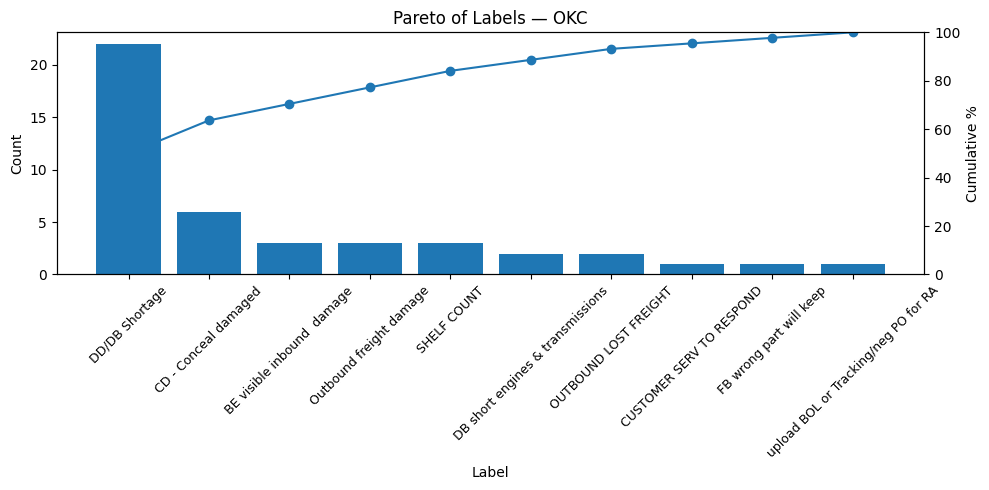

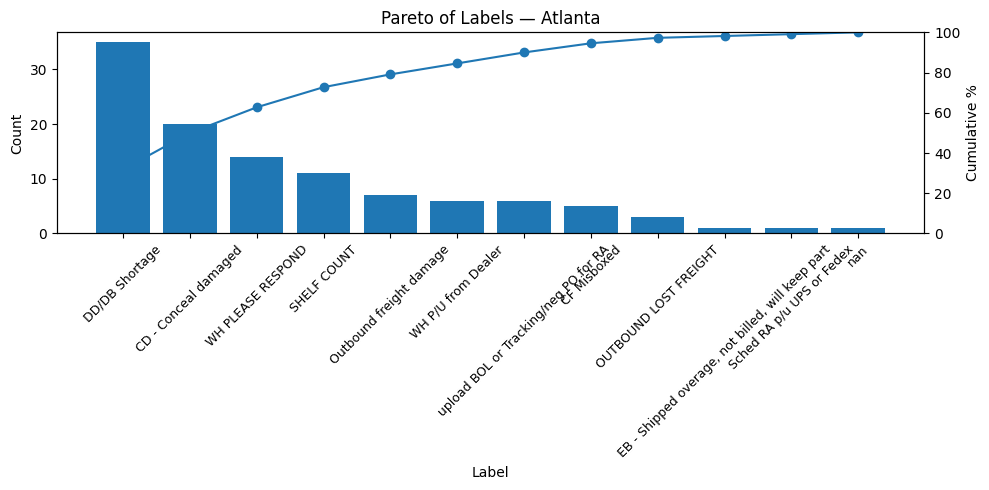

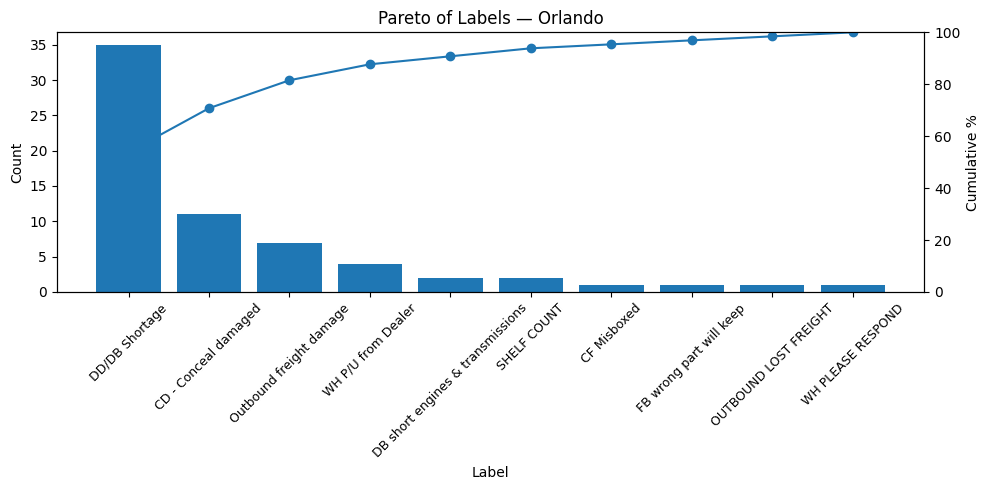

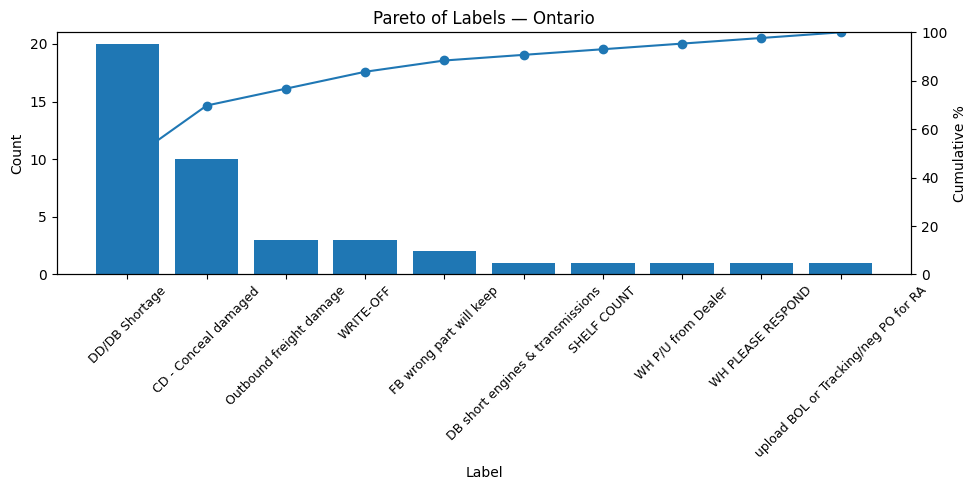

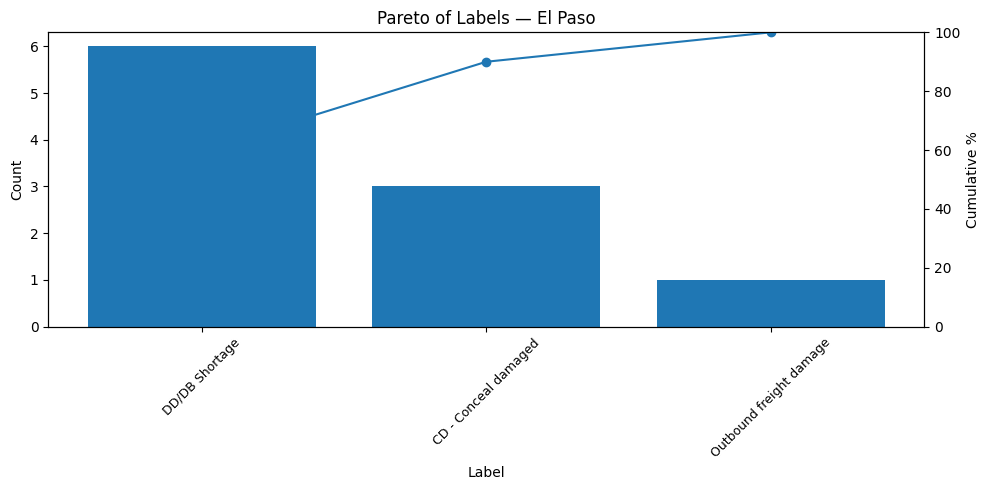

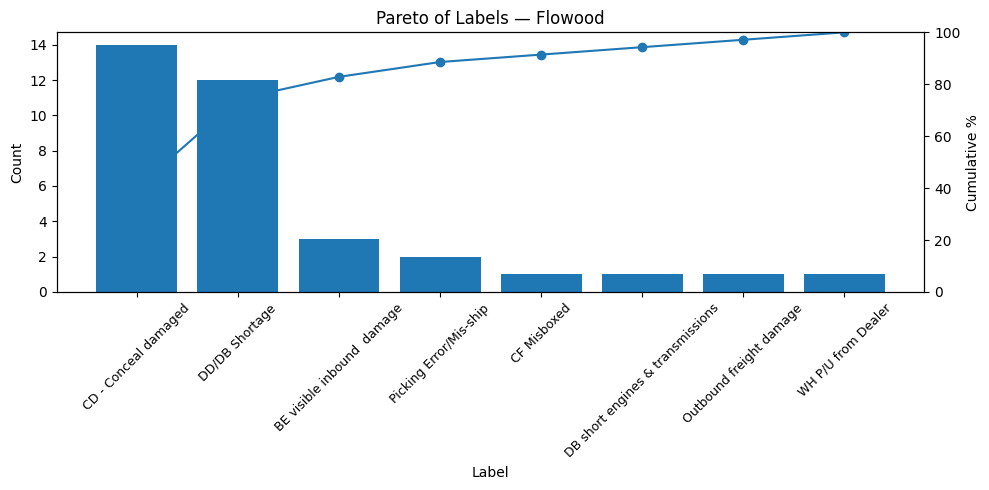

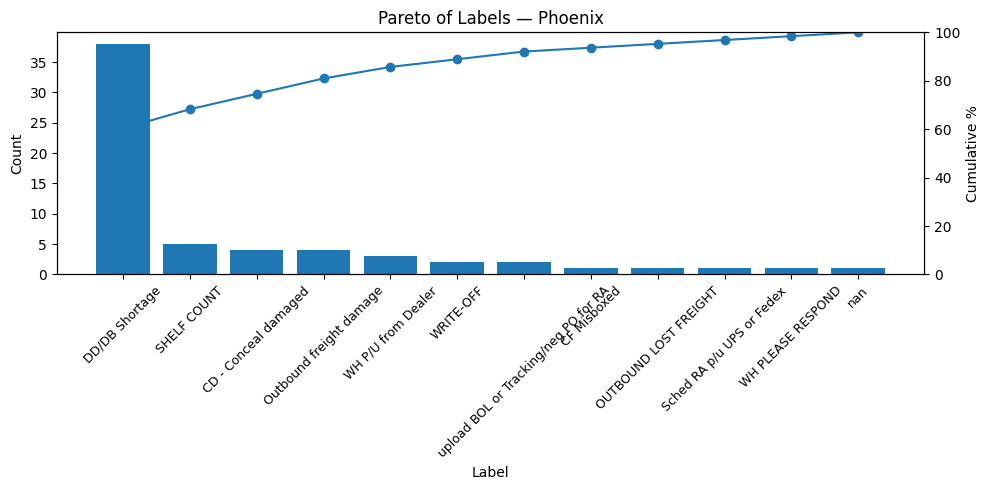

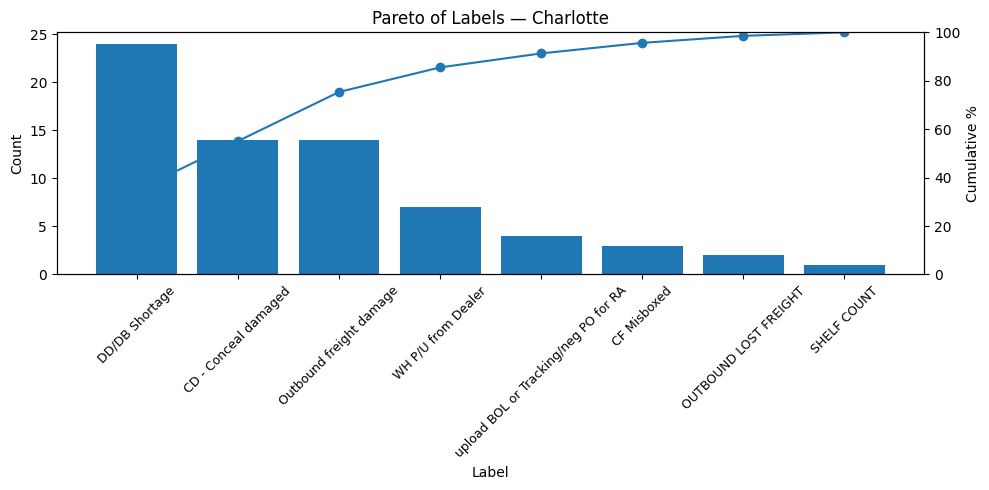

,Warehouse,Labels,Count,Percent,Cumulative %
2,Atlanta,DD/DB Shortage,35,31.82,31.82
0,Atlanta,CD - Conceal damaged,20,18.18,50.00
9,Atlanta,WH PLEASE RESPOND,14,12.73,62.73
6,Atlanta,SHELF COUNT,11,10.00,72.73
5,Atlanta,Outbound freight damage,7,6.36,79.09
8,Atlanta,WH P/U from Dealer,6,5.45,84.55
11,Atlanta,upload BOL or Tracking/neg PO for RA,6,5.45,90.00
1,Atlanta,CF Misboxed,5,4.55,94.55
4,Atlanta,OUTBOUND LOST FREIGHT,3,2.73,97.27
3,Atlanta,"EB - Shipped overage, not billed, will keep part",1,0.91,98.18


In [ ]:
# ----------------------------
# Pareto - Labels by Warehouse (Bucket Name)
# ----------------------------
# Keep only the configured warehouses
wh_mask = labels_exploded["Bucket Name"].isin(WAREHOUSES)
labels_by_wh = labels_exploded.loc[wh_mask].copy()
labels_by_wh.rename(columns={"Bucket Name": "Warehouse"}, inplace=True)

# Count labels per warehouse
counts = (
    labels_by_wh.groupby(["Warehouse", "Labels"])
                .size()
                .reset_index(name="Count")
)

# Compute within-warehouse percent and cumulative percent
counts["Percent"] = counts.groupby("Warehouse")["Count"].transform(lambda x: (x / x.sum()) * 100)
counts["Percent"] = counts["Percent"].round(2)

# Sort and compute cumulative % per warehouse
counts = counts.sort_values(["Warehouse", "Count"], ascending=[True, False])
counts["Cumulative %"] = (
    counts.groupby("Warehouse")["Count"]
          .transform(lambda x: x.cumsum() / x.sum() * 100)
          .round(2)
)

# Save a copy for export
labels_by_wh_table = counts.copy()

# ----------------------------
# Plot Pareto for each warehouse
# ----------------------------
def plot_pareto_for_warehouse(sub, warehouse, top_n=15):
    sub_sorted = sub.sort_values("Count", ascending=False)
    if top_n is not None:
        sub_sorted = sub_sorted.head(int(top_n))

    labels = sub_sorted["Labels"].tolist()
    counts_ = sub_sorted["Count"].tolist()
    cum_pct = sub_sorted["Cumulative %"].tolist()

    fig = plt.figure(figsize=(10, 5))  # one chart per figure (no subplots)
    ax1 = plt.gca()
    ax1.bar(labels, counts_)
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")
    ax1.set_title(f"Pareto of Labels — {warehouse}")

    # Cumulative percent on a second y-axis
    ax2 = ax1.twinx()
    ax2.plot(range(len(labels)), cum_pct, marker="o")
    ax2.set_ylabel("Cumulative %")
    ax2.set_ylim(0, 100)

    # Rotate x labels for readability
    ax1.tick_params(axis="x", rotation=45, labelsize=9)
    fig.tight_layout()
    plt.show()

# Generate charts
for wh in WAREHOUSES:
    sub = counts[counts["Warehouse"] == wh]
    if not sub.empty:
        plot_pareto_for_warehouse(sub, wh, top_n=TOP_N_LABELS)

# Preview the first few rows of the by-warehouse table
labels_by_wh_table.head(20)


## Export for Power BI

The following tables are written to `Claims_Performance_Summary.xlsx`:
- `Bucket_Performance`
- `Pareto_Labels_Overall`
- `Pareto_Labels_By_Warehouse` (long format: Warehouse, Label, Count, Percent, Cumulative %)

You can import these sheets directly into **Power BI** (Get Data → Excel). Because tables are rebuilt on each run, you can refresh your Power BI model as data updates.


In [ ]:
# ----------------------------
# Export to Excel for Power BI
# ----------------------------
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    bucket_perf.to_excel(writer, sheet_name="Bucket_Performance", index=False)
    labels_overall.to_excel(writer, sheet_name="Pareto_Labels_Overall", index=False)
    labels_by_wh_table.to_excel(writer, sheet_name="Pareto_Labels_By_Warehouse", index=False)

print(f"Exported Power BI workbook -> {OUTPUT_XLSX.resolve()}")


Exported Power BI workbook -> C:\Users\dbalan\Desktop\Python\Github\Claims\Claims_Performance_Summary.xlsx


## Next Steps
- Connect `Claims_Performance_Summary.xlsx` to **Power BI** and build visuals from the exported tables.
- Optionally schedule automatic refresh tied to a data export process (e.g., Planner/Service tool → Excel) so your dashboard stays current.
